In [ ]:
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import perf_counter
from pathlib import Path
from IPython.display import Image, display, Markdown

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def printmd(string):
    display(Markdown(string))

In [ ]:
imageDir = Path('/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images')

filepaths = list(imageDir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df

Filepath           Label
0     /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate
1     /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate
2     /content/drive/MyDrive/Hacktech/gaussian_filte...          Severe
3     /content/drive/MyDrive/Hacktech/gaussian_filte...  Proliferate_DR
4     /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate
...                                                 ...             ...
3657  /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate
3658  /content/drive/MyDrive/Hacktech/gaussian_filte...          Severe
3659  /content/drive/MyDrive/Hacktech/gaussian_filte...           No_DR
3660  /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate
3661  /content/drive/MyDrive/Hacktech/gaussian_filte...        Moderate

[3662 rows x 2 columns]

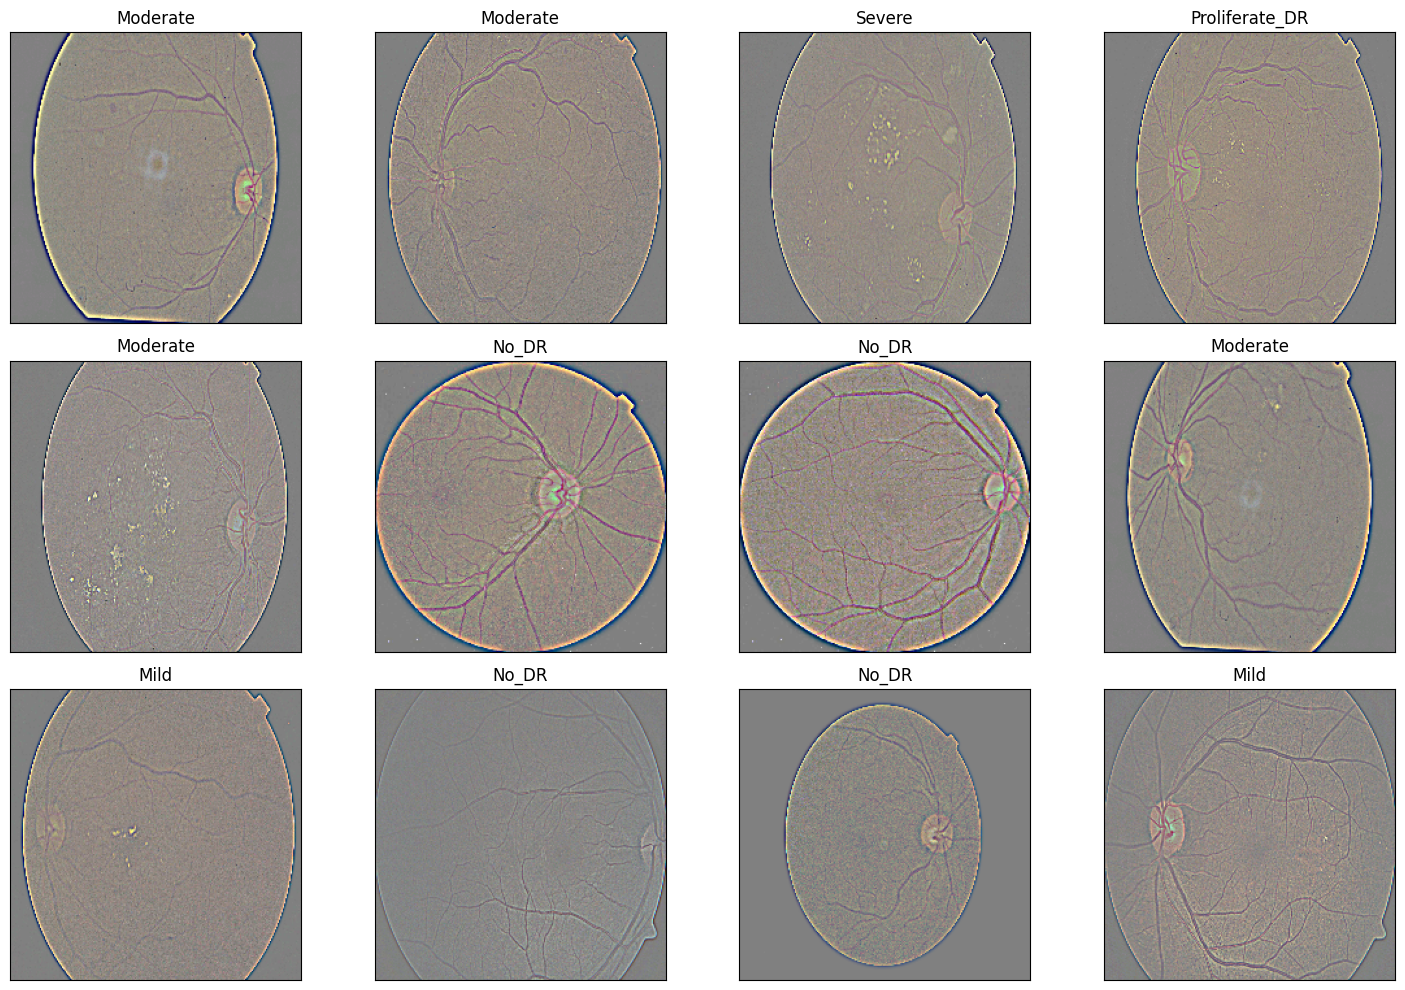

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.show()

<ipython-input-6-bc620c70a18d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc, palette="rocket")


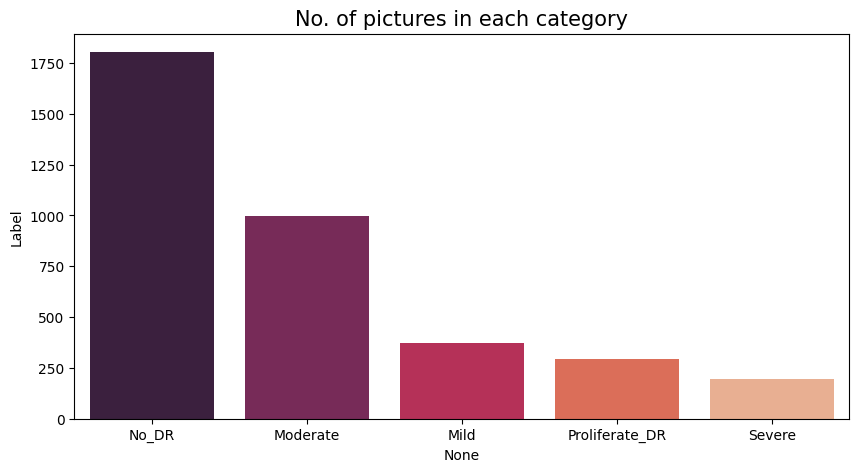

In [ ]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("No. of pictures in each category", fontsize=15)
plt.show()

In [ ]:
def createGen():
    trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    trainImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    testImages = testGen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return trainGen, testGen, trainImages, valImages, testImages

In [ ]:
def getModel(model):
    kwargs = {
        'input_shape':(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'avg'
    }

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [ ]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

for name, model in models.items():
    X = getModel(model['model'])
    models[name]['model'] = X

    start = perf_counter()
    history = X.fit(trainImages, validation_data=valImages, epochs=10)

    duration = round((perf_counter() - start), 2)
    models[name]['perf'] = duration
    print(f"{name:20} -> trained in -> {duration} Sec")

    valAcc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in valAcc]

    trainAcc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in trainAcc]
modelsResult = []

for name, v in models.items():
    modelsResult.append(
        [
            name,
            models[name]['train_accuracy'][-1],
            models[name]['val_acc'][-1],
            models[name]['perf']
        ]
    )

dfResults = pd.DataFrame(
    modelsResult,
    columns = [
        'Model',
        'train_accuracy',
        'val_accuracy',
        'Training time (sec)'
    ]
)

dfResults.sort_values(by='val_accuracy', ascending=False, inplace=True)
dfResults.reset_index(inplace=True, drop=True)
dfResults

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


ValueError: The first argument to `Layer.call` must always be passed.

NameError: name 'dfResults' is not defined

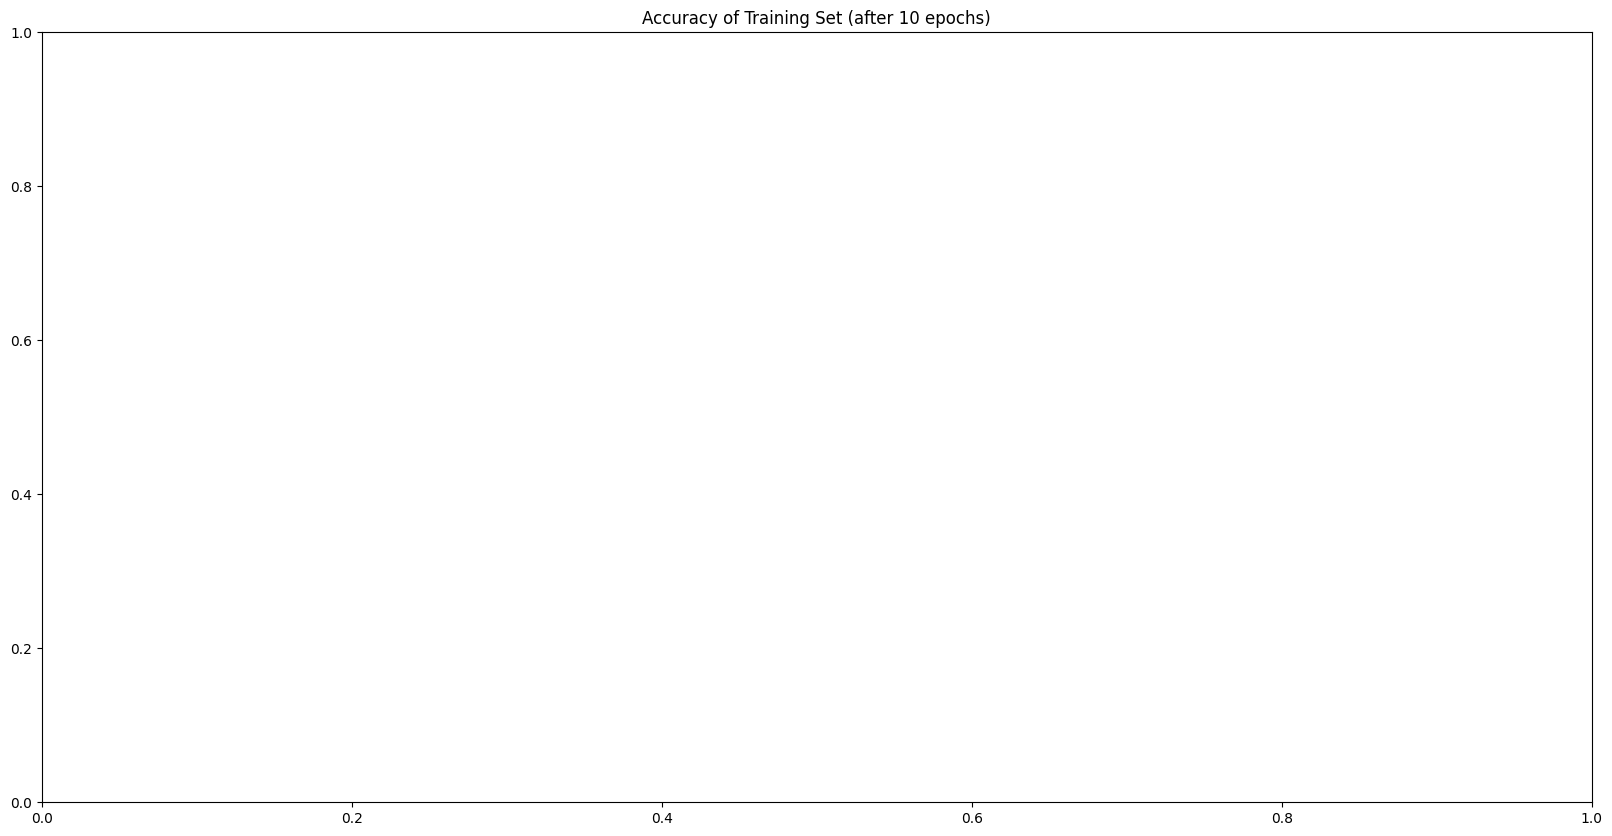

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Training Set (after 10 epochs)', fontsize=12)
sns.barplot(x='Model', y='train_accuracy', data=dfResults)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Model', y='Training time (sec)', data=dfResults)
plt.title('Training time for each model in (Sec)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
93/93 [==============================] - 215s 2s/step - loss: 0.7872 - accuracy: 0.7087 - val_loss: 0.7190 - val_accuracy: 0.7477
Epoch 2/10
93/93 [==============================] - 174s 2s/step - loss: 0.6297 - accuracy: 0.7690 - val_loss: 0.7017 - val_accuracy: 0.7386
Epoch 3/10
93/93 [==============================] - 172s 2s/step - loss: 0.5885 - accuracy: 0.7751 - val_loss: 0.6578 - val_accuracy: 0.7599
Epoch 4/10
93/93 [==============================] - 175s 2s/step - loss: 0.5294 - accuracy: 0.8007 - val_loss: 0.6578 - val_accuracy: 0.7568
Epoch 5/10
93/93 [==============================] - 178s 2s/step - loss: 0.5163 - accuracy: 0.8102 - val_loss: 0.6556 - val_accuracy: 0.7660
Epoch 6/10
93/93 [==============================] - 175s 2s/step - loss: 0.4723 - accuracy: 0.8237 - val_loss: 0.6787 - val_accuracy: 0.7508
Epoch 7/10
93/93 [==============================] - 172s 2s/step - loss: 0.4486 - accuracy: 0.8321 - val_loss: 0.6930 - val_accuracy: 0.7386


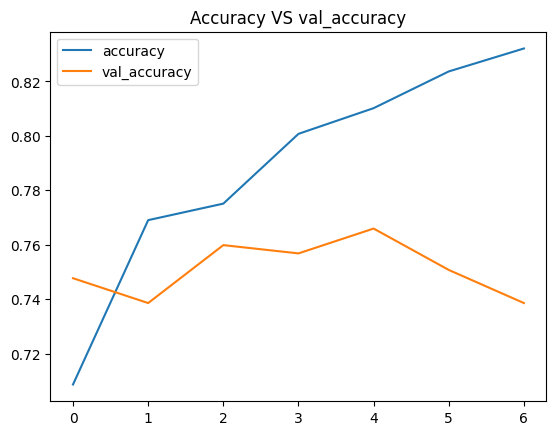

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy VS val_accuracy")
plt.show()

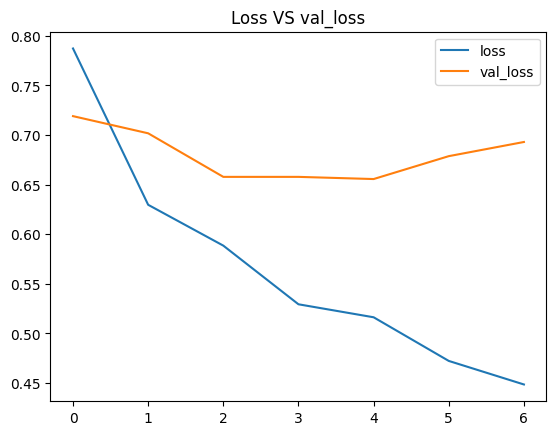

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss VS val_loss")
plt.show()

In [ ]:
results = model.evaluate(testImages, verbose=0)

print('> ## Test Loss |> {:.5f}'.format(results[0]))
print('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

> ## Test Loss |> 0.63155
> ## Accuracy |> 75.20%


In [ ]:
pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]

print(f'The first 10 predictions:\n{pred[:10]}')

12/12 [==============================] - 30s 2s/step
The first 10 predictions:
['Moderate', 'No_DR', 'No_DR', 'No_DR', 'Moderate', 'Mild', 'No_DR', 'No_DR', 'Proliferate_DR', 'Moderate']


In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.53      0.55      0.54        38
      Moderate       0.65      0.60      0.62        98
         No_DR       0.93      0.99      0.96       175
Proliferate_DR       0.50      0.54      0.52        35
        Severe       0.36      0.19      0.25        21

      accuracy                           0.75       367
     macro avg       0.59      0.58      0.58       367
  weighted avg       0.74      0.75      0.74       367



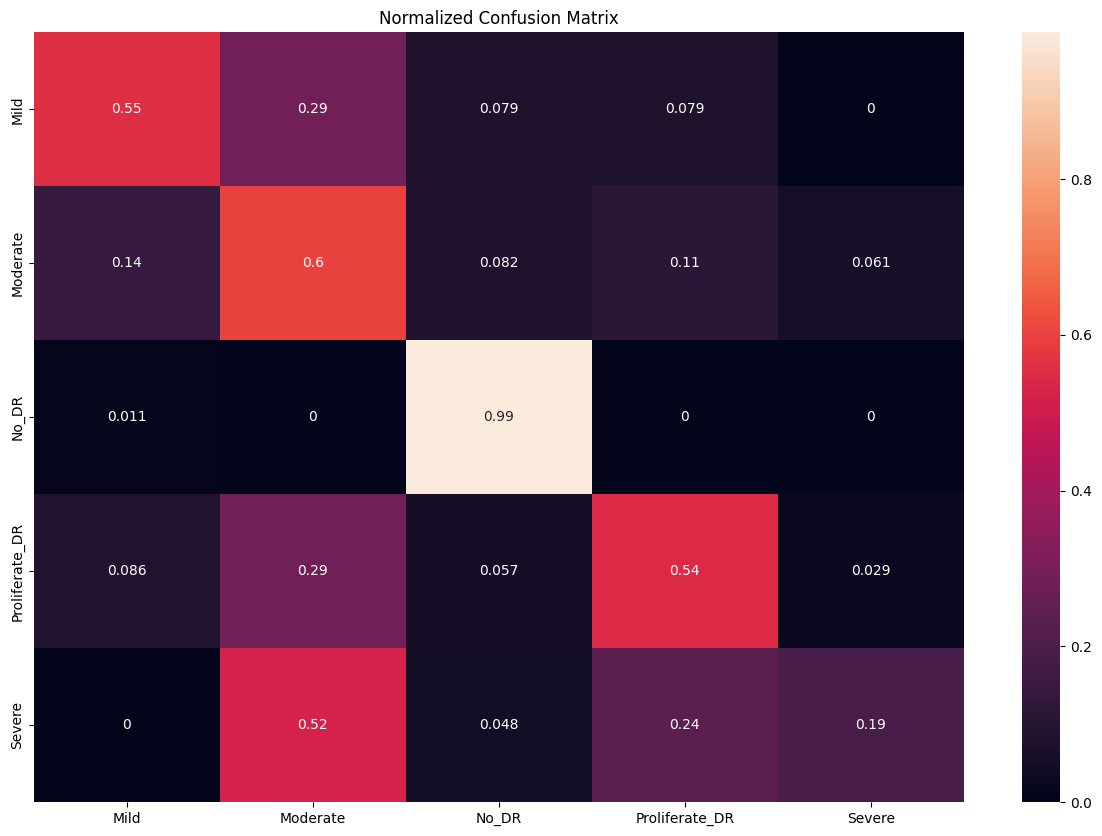

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15, 10))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

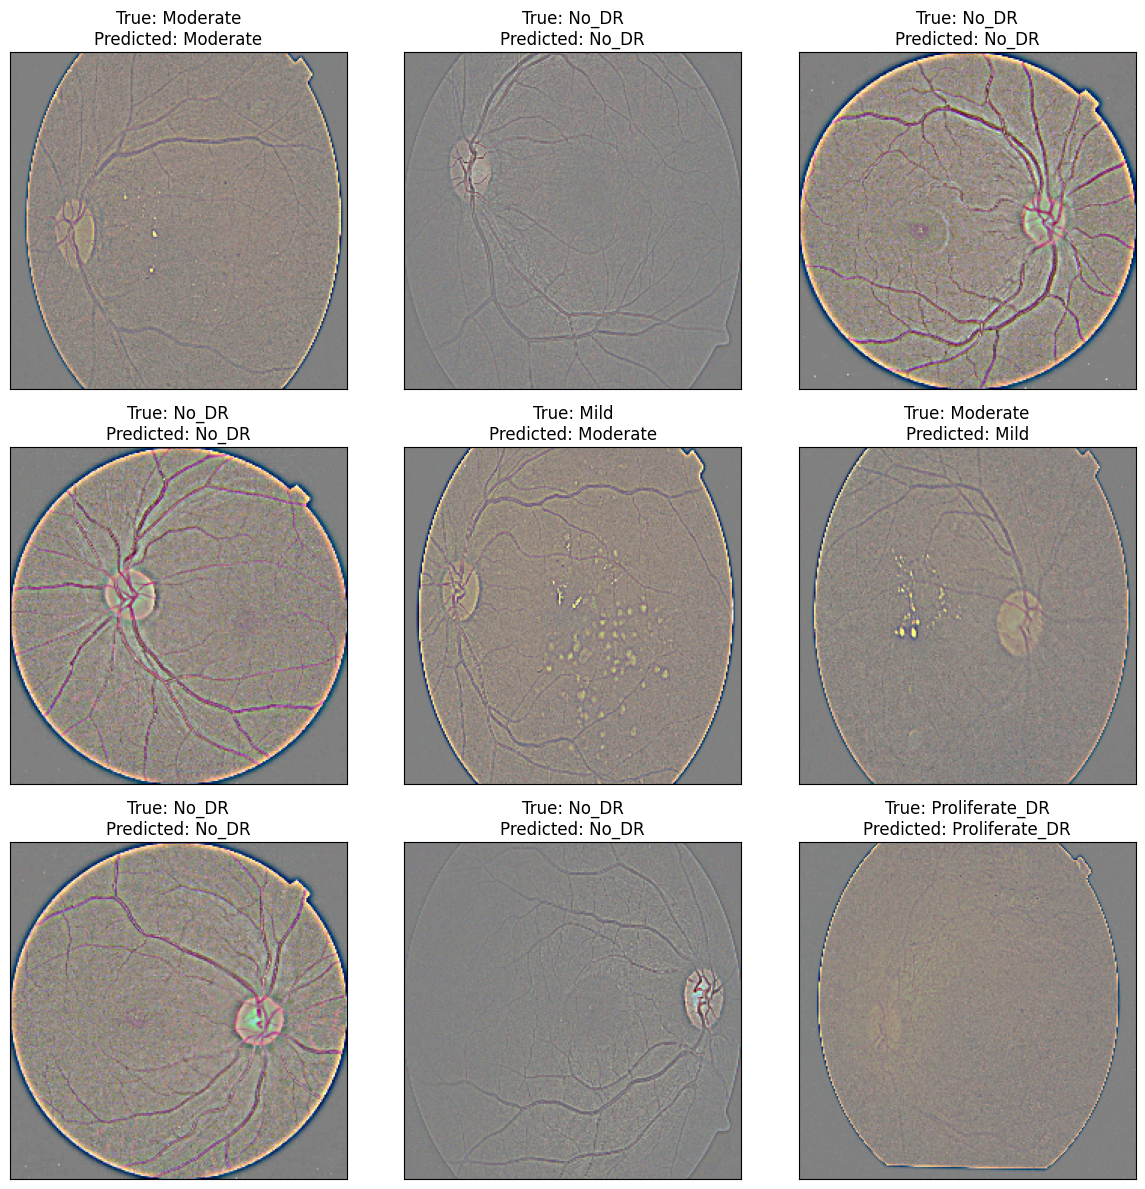

In [ ]:
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 12),
    subplot_kw={'xticks':[], 'yticks':[]}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')

plt.tight_layout()
plt.show()

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    return cam_path

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224, 224)

model.layers[-1].activation = None

/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/Moderate/295fdc964f6e.png


<ipython-input-28-85b40b528ecc>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/No_DR/1ca62b3e4fd3.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/No_DR/39f8935185e6.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/No_DR/ff59d44a70a7.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/Mild/89ed6a0dd53f.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/Moderate/1177d583c807.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/No_DR/784d6d302f98.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/No_DR/fa0c87bd75ce.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/de16416220de.png
/content/drive/MyDrive/Hacktech/gaussian_filtered_images/gaussian_filtered_images/Moderate/29580bed2f7d.png
/content/drive/MyDrive/Hacktech/gaussian_

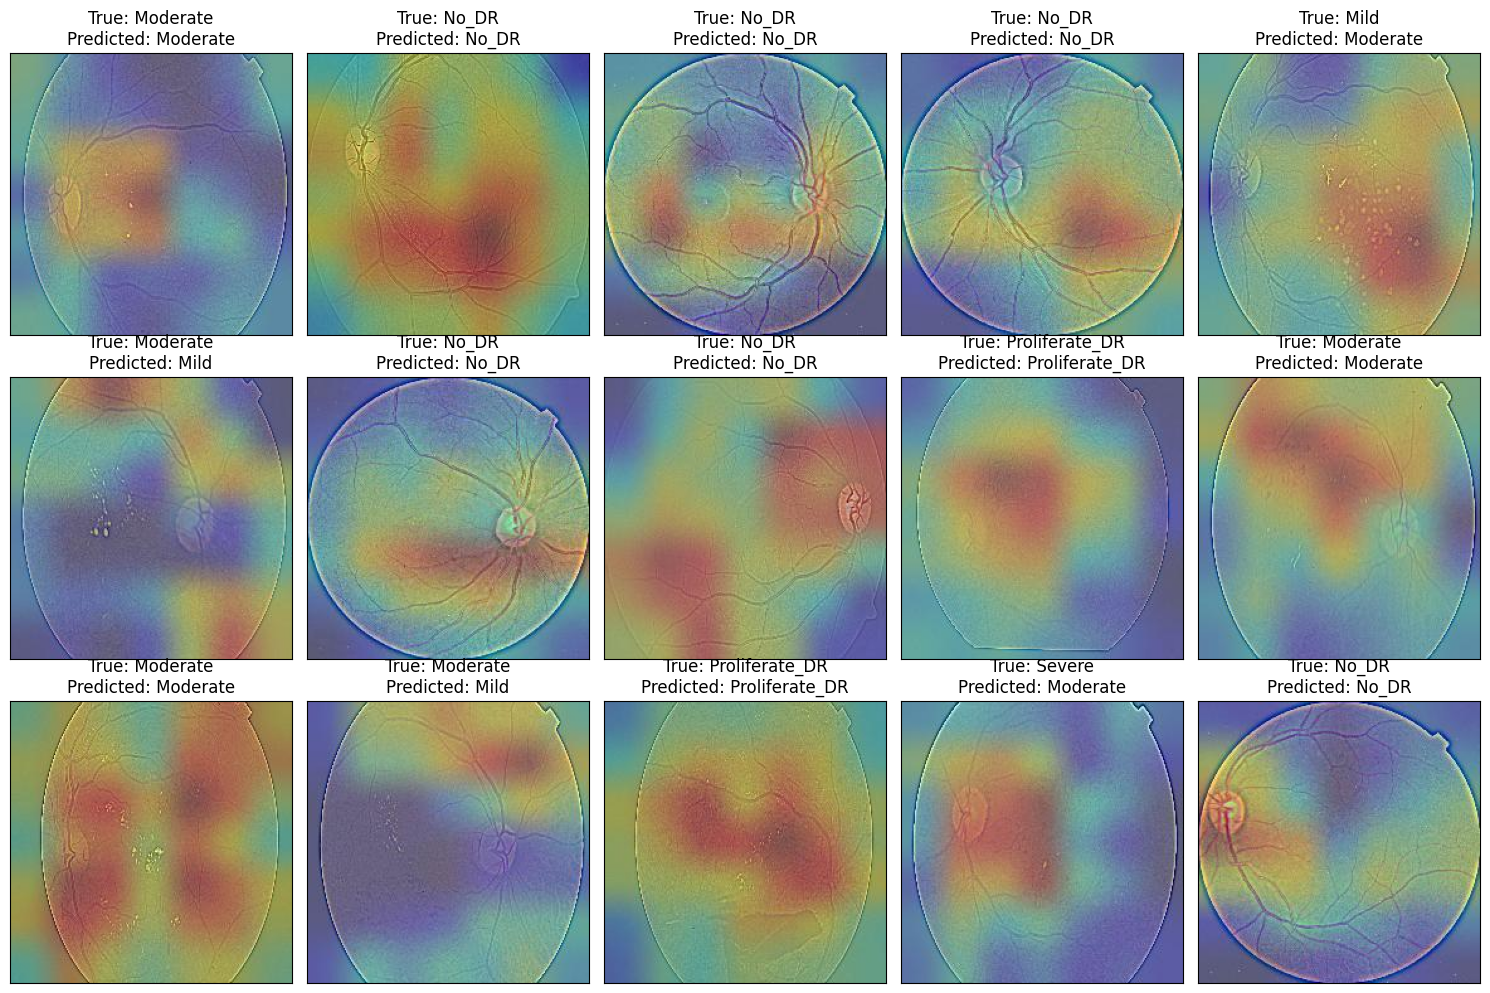

In [ ]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=5,
    figsize=(15, 10),
    subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    print(img_path)
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")

plt.tight_layout()
plt.show()

In [ ]:
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x=='No_DR' else 'DR')
image_df_red

In [ ]:
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(12, 9))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=12)
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("ACCURACY -> vs <- val_accuracy")
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("LOSS -> vs <- val_loss")
plt.show()

results = model.evaluate(testImages)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]
print(f'\n\nThe first 10 predictions:\n {pred[:10]}')

y_test = list(test_df.Label)
print(f'\n\n {classification_report(y_test, pred)}')

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (12, 9))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

NameError: name 'y_test' is not defined